<a href="https://www.kaggle.com/code/rashidrk/malaria-detection-with-yolo11-84-8-map50?scriptVersionId=215855362" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Yolo11

Yolo11, developed by Ultralytics, is the latest model in the YOLO (You Only Look Once) series. As of the creation of this notebook, it stands out for its remarkable improvements in performance over its predecessors. The enhanced capabilities of Yolo11 are clearly illustrated in the performance comparison below:

![Yolo11 performance](https://raw.githubusercontent.com/ultralytics/assets/refs/heads/main/yolo/performance-comparison.png)

<center>Source: https://docs.ultralytics.com/models/yolo11/#overview</center>

In this notebook, we will explore how to fine-tune Yolo11 for a specialized task: **Malaria Detection.**


# Import the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
!pip install ultralytics -q
from PIL import Image, ImageDraw
from pathlib import Path
import os
import xml.etree.ElementTree as ET
from typing import List
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 30.3 MB/s eta 0:00:00


In [2]:
annotations_path = Path("/kaggle/input/makerere-malaria-dataset/annotation")
images_path = Path("/kaggle/input/makerere-malaria-dataset/images")

annotations = os.listdir(annotations_path)
images = os.listdir(images_path)

annotations.sort()
images.sort()

In [3]:
data_df = pd.DataFrame({"annotations" : annotations,
                        "images" : images})

data_df['annotations'] = data_df['annotations'].apply(lambda x : annotations_path / Path(x))
data_df['images'] = data_df['images'].apply(lambda x : images_path / Path(x))

data_df.head()

,annotations,images
0,/kaggle/input/makerere-malaria-dataset/annotat...,/kaggle/input/makerere-malaria-dataset/images/...
1,/kaggle/input/makerere-malaria-dataset/annotat...,/kaggle/input/makerere-malaria-dataset/images/...
2,/kaggle/input/makerere-malaria-dataset/annotat...,/kaggle/input/makerere-malaria-dataset/images/...
3,/kaggle/input/makerere-malaria-dataset/annotat...,/kaggle/input/makerere-malaria-dataset/images/...
4,/kaggle/input/makerere-malaria-dataset/annotat...,/kaggle/input/makerere-malaria-dataset/images/...


# Data processing

In [4]:
def parse_xml(xml_file_path):
    """
    Parses the given XML content and extracts relevant information.
    
    Returns:
        dict: A dictionary containing parsed data.
    """
    # Parse the XML content
    root = ET.parse(xml_file_path)
    
    # Extract database source
    database = root.find("./source/database").text if root.find("./source/database") is not None else None
    
    # Extract image size information
    size = root.find("./size")
    width = size.find("width").text if size.find("width") is not None else None
    height = size.find("height").text if size.find("height") is not None else None
    depth = size.find("depth").text if size.find("depth") is not None else None
    
    # Extract object information
    objects = []
    for obj in root.findall("./object"):
        name = obj.find("name").text if obj.find("name") is not None else None
        action = obj.find("action").text if obj.find("action") is not None else None
        bndbox = obj.find("bndbox")
        if bndbox:
            xmin = bndbox.find("xmin").text if bndbox.find("xmin") is not None else None
            ymin = bndbox.find("ymin").text if bndbox.find("ymin") is not None else None
            xmax = bndbox.find("xmax").text if bndbox.find("xmax") is not None else None
            ymax = bndbox.find("ymax").text if bndbox.find("ymax") is not None else None
        else:
            xmin, ymin, xmax, ymax = None, None, None, None
        
        objects.append({
            "name": name,
            "action": action,
            "bounding_box": {
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax,
            }
        })
    
    # Return parsed data as a dictionary
    return {
        "database": database,
        "size": {
            "width": width,
            "height": height,
            "depth": depth
        },
        "objects": objects
    }

In [5]:
parse_xml(data_df['annotations'].iloc[12])

{'database': 'Makerere laboratory images database',
 'size': {'width': '1024', 'height': '768', 'depth': '3'},
 'objects': [{'name': 'person',
   'action': 'Trophozoite',
   'bounding_box': {'xmin': '408.8882',
    'ymin': '607.646',
    'xmax': '458.8882',
    'ymax': '657.646'}},
  {'name': 'person',
   'action': 'Trophozoite',
   'bounding_box': {'xmin': '537.6832',
    'ymin': '530.1304',
    'xmax': '587.6832',
    'ymax': '580.1304'}},
  {'name': 'person',
   'action': 'Trophozoite',
   'bounding_box': {'xmin': '702.2547',
    'ymin': '514.6273',
    'xmax': '752.2547',
    'ymax': '564.6273'}},
  {'name': 'person',
   'action': 'Trophozoite',
   'bounding_box': {'xmin': '453.0124',
    'ymin': '645.8075',
    'xmax': '503.0124',
    'ymax': '695.8075'}},
  {'name': 'person',
   'action': 'Trophozoite',
   'bounding_box': {'xmin': '416.0435',
    'ymin': '685.1615',
    'xmax': '466.0435',
    'ymax': '735.1615'}},
  {'name': 'person',
   'action': 'Trophozoite',
   'bounding_box

In [6]:
IMG_WIDTH = 1024 
IMG_HEIGHT = 768

In [7]:
def plot_bounding_boxes(image_path, objects):
    """
    Plots bounding boxes on the image and optionally saves the output.
    
    Args:
        image_path : Path to the input image.
        objects : List of dictionaries containing bounding box data.
        
    Returns:
        None: Displays the image with bounding boxes.
    """
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes
    for obj in objects:
        bbox = obj['bounding_box']
        if all([bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]]):  # Ensure all coordinates exist
            xmin = float(bbox["xmin"])
            ymin = float(bbox["ymin"])
            xmax = float(bbox["xmax"])
            ymax = float(bbox["ymax"])
            
            # Draw rectangle
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
            
            # Add label
            if obj["action"]:
                label = obj["action"]
                draw.text((xmin, ymin - 10), label, fill="red")
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

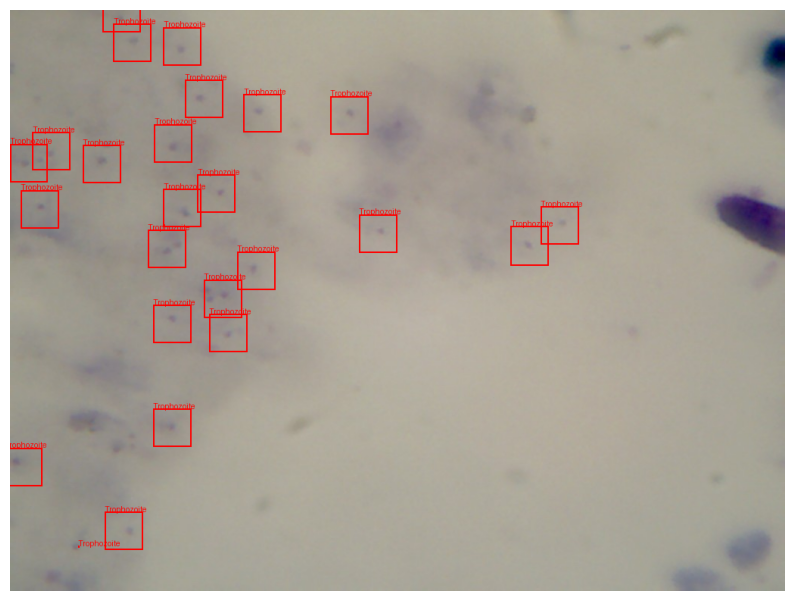

In [8]:
sample = data_df.loc[10]
objects = parse_xml(sample['annotations'])['objects']

plot_bounding_boxes(sample['images'], objects)

In [9]:
train_data, test_data = train_test_split(data_df, random_state = 42, test_size = 0.2)
train_data, val_data = train_test_split(train_data, random_state = 42, test_size = 0.1)
train_data.shape, test_data.shape, val_data.shape

((1945, 2), (541, 2), (217, 2))

In [10]:
sample['annotations'].name

'plasmodium-0010.xml'

# Prepare the data for training

In [11]:
def convert_to_yolo_format(xml_path, output_dir):
    """
    Converts XML annotations to YOLO format.

    Args:
        xml_path: Path to the XML annotation file.
        output_dir: Directory to save the YOLO annotation files.

    Returns:
        None: Saves YOLO annotation files to output_dir.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # YOLO annotations
    yolo_annotations = []

    for obj in root.findall("object"):
        # Get bounding box
        bndbox = obj.find("bndbox")
        xmin = float(bndbox.find("xmin").text)
        ymin = float(bndbox.find("ymin").text)
        xmax = float(bndbox.find("xmax").text)
        ymax = float(bndbox.find("ymax").text)

        # Normalize the coordinates
        x_center = ((xmin + xmax) / 2) / IMG_WIDTH
        y_center = ((ymin + ymax) / 2) / IMG_HEIGHT
        box_width = (xmax - xmin) / IMG_WIDTH
        box_height = (ymax - ymin) / IMG_HEIGHT

        # Format: <class_id> <x_center> <y_center> <width> <height>
        #class is 0 because it's only one class
        yolo_annotations.append(f"0 {x_center} {y_center} {box_width} {box_height}")

    # Save to YOLO file
    output_file = output_dir / Path(xml_path.name[:-3] + "txt")
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_annotations))


In [12]:
output_dir = Path("/kaggle/working/")

directories = ['train', 'val', 'test']
for data_dir in directories:
    images_output_dir = output_dir / f"{data_dir}/images"
    labels_output_dir = output_dir / f"{data_dir}/labels"

    os.makedirs(images_output_dir, exist_ok = True)
    os.makedirs(labels_output_dir, exist_ok = True)

In [13]:
directories_dict = {
    "train" : Path("/kaggle/working/train"),
    "test" : Path("/kaggle/working/test"),
    "val" : Path("/kaggle/working/val")
}

In [14]:
def move_image_to_dir(image_path, images_output_dir):
    """
    Resize and move an image to the specified directory.
    
    Args:
        image_path (str): Path to the source image.
        images_output_dir (Path): Directory to save the resized image.
    """
    image = Image.open(image_path)
    images_output_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    image.save(images_output_dir / Path(image_path).name)


def generate_yolo_dir(df: pd.DataFrame, data_dir: str):
    """
    Generate directories for YOLO by processing images and annotations.

    Args:
        df (pd.DataFrame): DataFrame with 'images' and 'annotations' columns.
        data_dir (str): Parent directory for 'images' and 'labels' folders.
    """
    images_output_dir = Path(directories_dict[data_dir]) / "images"
    labels_output_dir = Path(directories_dict[data_dir]) / "labels"
    
    for img_path, annotations_path in tqdm(
        zip(df['images'].values, df['annotations'].values), 
        total=len(df), 
        desc="Processing Images and Annotations"
    ):        
        move_image_to_dir(img_path, images_output_dir)
        convert_to_yolo_format(annotations_path, labels_output_dir)

In [15]:
generate_yolo_dir(train_data, "train")

Processing Images and Annotations: 100%|██████████| 1945/1945 [00:31<00:00, 62.20it/s]


In [16]:
# display one of the files
with open("/kaggle/working/train/labels/plasmodium-0734.txt") as f:
    print(f.read())

0 0.110442578125 0.516304296875 0.048828125 0.06510416666666667
0 0.71719716796875 0.04270182291666667 0.048828125 0.06510416666666667
0 0.91401396484375 0.9246894531250001 0.048828125 0.06510416666666667


In [17]:
generate_yolo_dir(test_data, "test")

Processing Images and Annotations: 100%|██████████| 541/541 [00:08<00:00, 60.66it/s]


In [18]:
generate_yolo_dir(val_data, "val")

Processing Images and Annotations: 100%|██████████| 217/217 [00:03<00:00, 57.67it/s]


# Create the YaML file

In [19]:
num_classes = 1
names = ["Trophozoite"]

dict_file = {
    'train': str(directories_dict['train']),
    'val': str(directories_dict['val']),
    'test': str(directories_dict['test']),
    'nc': num_classes,
    'names': names,
    'augment': { # apply data augmentations
        'flipud': 0.0,  # Probability of vertical flip
        'fliplr': 0.5,  # Probability of horizontal flip
        'hsv_h': 0.015,  # HSV hue augmentation 
        'hsv_s': 0.7,  # HSV saturation augmentation
        'hsv_v': 0.4   # HSV value augmentation
    }
}

# Save to the data.yaml file
with open("/kaggle/working/data.yaml", 'w') as file:
    yaml.dump(dict_file, file, default_flow_style=False)


In [20]:
# display 
with open("/kaggle/working/data.yaml", "r") as f:
    print(f.read())

augment:
  fliplr: 0.5
  flipud: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
names:
- Trophozoite
nc: 1
test: /kaggle/working/test
train: /kaggle/working/train
val: /kaggle/working/val



# Train

In [21]:
#configure weights and biases
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
except Exception as e:
    print(e)
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rashidkisejjere0784. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
from ultralytics import YOLO

model = YOLO('yolo11s.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 94.1MB/s]


In [23]:
results = model.train(data="/kaggle/working/data.yaml",
                      epochs=50,
                      imgsz=640,
                      patience=40,
                      cos_lr = True,
                      seed = 42)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 45.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 198MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 1945 images, 202 backgrounds, 0 corrupt: 100%|██████████| 1945/1945 [00:01<00:00, 1107.07it/s]

train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0050.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0052.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0103.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0205.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0232.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0262.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0562.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0652.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0825.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/plasmodium-0971.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/train/images/pla

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/val/labels... 217 images, 36 backgrounds, 0 corrupt: 100%|██████████| 217/217 [00:00<00:00, 1142.30it/s]

val: WARNING ⚠️ /kaggle/working/val/images/plasmodium-0575.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.39G      2.269      1.739      1.323        246        640: 100%|██████████| 122/122 [00:44<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


                   all        217       4036      0.375      0.238      0.202     0.0536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.12G      2.044      1.434      1.217        508        640: 100%|██████████| 122/122 [00:41<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


                   all        217       4036      0.645      0.611      0.584      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.23G      2.011       1.38       1.21        256        640: 100%|██████████| 122/122 [00:41<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


                   all        217       4036      0.556      0.467      0.451     0.0833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.71G      1.991      1.355      1.207        180        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


                   all        217       4036      0.739      0.763      0.745      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.19G      1.968      1.336      1.188        197        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        217       4036      0.631      0.608      0.589      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         5G      1.925      1.317      1.179        310        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


                   all        217       4036      0.724      0.673      0.677      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.18G      1.901      1.299      1.154        335        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


                   all        217       4036      0.738      0.692       0.72      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.8G      1.905      1.311      1.161        162        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


                   all        217       4036      0.741      0.784      0.775      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.18G       1.84      1.271       1.14        214        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


                   all        217       4036      0.774      0.749      0.771      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.36G       1.87      1.282      1.143        316        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        217       4036      0.692      0.616      0.663      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.97G      1.806      1.282      1.131        206        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


                   all        217       4036      0.702      0.586      0.626      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.18G       1.77      1.251      1.119        127        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


                   all        217       4036      0.779      0.773      0.792       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.21G      1.795      1.278      1.125        224        640: 100%|██████████| 122/122 [00:41<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        217       4036      0.786       0.78      0.802      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.18G      1.752      1.249      1.104        170        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


                   all        217       4036      0.792      0.762      0.772      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.31G      1.721      1.249      1.098        345        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        217       4036      0.789       0.78      0.792      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.32G      1.694      1.264      1.095        240        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        217       4036      0.736      0.674      0.705      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.08G      1.687      1.236      1.078        314        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


                   all        217       4036      0.782      0.835      0.822      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.34G      1.689       1.24      1.085        206        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        217       4036      0.803      0.711      0.767      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.19G      1.693      1.247      1.089        214        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        217       4036      0.798       0.81      0.817      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.14G      1.666      1.239      1.078        211        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        217       4036      0.816       0.76      0.793      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.27G      1.661      1.231      1.072        107        640: 100%|██████████| 122/122 [00:41<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        217       4036      0.806      0.799       0.82      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.29G      1.649      1.223      1.067        316        640: 100%|██████████| 122/122 [00:41<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        217       4036      0.807      0.754      0.789      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.16G       1.63      1.238      1.064        241        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        217       4036      0.797       0.83      0.818       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.35G      1.612      1.219      1.061        229        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


                   all        217       4036      0.805      0.811      0.829      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.91G      1.601      1.241      1.059        243        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


                   all        217       4036      0.781      0.826      0.827      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.25G      1.616      1.219      1.052        332        640: 100%|██████████| 122/122 [00:41<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        217       4036       0.81      0.803       0.82      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.27G      1.593      1.218      1.047        358        640: 100%|██████████| 122/122 [00:41<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


                   all        217       4036      0.824      0.822      0.837      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.62G      1.579      1.228      1.051        300        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        217       4036      0.825      0.816      0.828      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.24G      1.563      1.234      1.042        227        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        217       4036      0.814      0.833      0.834      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.26G      1.549      1.221      1.035        160        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        217       4036       0.82      0.806      0.822      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.17G      1.552      1.233      1.036        253        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        217       4036      0.823      0.821       0.84      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.92G      1.551      1.219       1.04        260        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        217       4036      0.819      0.821      0.832      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.28G      1.528      1.237      1.035        188        640: 100%|██████████| 122/122 [00:41<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        217       4036      0.812      0.837      0.831       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.37G      1.532      1.216      1.032        224        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


                   all        217       4036      0.837      0.785      0.827      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.96G      1.531      1.226      1.028        338        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        217       4036      0.824       0.83       0.84      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       5.2G       1.53      1.233      1.032        263        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


                   all        217       4036      0.826      0.838      0.842      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.69G      1.509      1.209      1.023        295        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


                   all        217       4036      0.791      0.855       0.83      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       5.1G      1.521      1.218      1.026        337        640: 100%|██████████| 122/122 [00:41<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


                   all        217       4036       0.82       0.84      0.849      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.32G      1.516      1.206      1.023        340        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        217       4036      0.828      0.834      0.838      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.16G       1.51      1.224      1.023        266        640: 100%|██████████| 122/122 [00:41<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        217       4036      0.815      0.851      0.836      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.98G       1.48      1.248      1.052        219        640: 100%|██████████| 122/122 [00:42<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        217       4036      0.824      0.831      0.842      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.64G      1.453      1.261      1.043        143        640: 100%|██████████| 122/122 [00:40<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


                   all        217       4036      0.835      0.824      0.845      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.63G      1.444       1.26      1.045        138        640: 100%|██████████| 122/122 [00:40<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        217       4036      0.831      0.831      0.839      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.83G      1.448      1.258       1.04        171        640: 100%|██████████| 122/122 [00:40<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


                   all        217       4036       0.83      0.831      0.841      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.67G      1.441      1.261      1.041        130        640: 100%|██████████| 122/122 [00:40<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        217       4036      0.829      0.837      0.841      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       4.8G      1.435       1.27      1.042        118        640: 100%|██████████| 122/122 [00:40<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        217       4036      0.834      0.829      0.841      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.76G      1.441      1.254      1.043        135        640: 100%|██████████| 122/122 [00:40<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


                   all        217       4036      0.831      0.839      0.848      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.86G      1.436      1.261      1.044        221        640: 100%|██████████| 122/122 [00:40<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


                   all        217       4036      0.821      0.848      0.842      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.73G       1.43      1.255      1.039         95        640: 100%|██████████| 122/122 [00:40<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


                   all        217       4036      0.828      0.841      0.845      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.87G      1.433       1.26      1.038        172        640: 100%|██████████| 122/122 [00:40<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


                   all        217       4036      0.831      0.837      0.844       0.39

50 epochs completed in 0.615 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


                   all        217       4036      0.831       0.84      0.848      0.393
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


In [24]:
results.results_dict

{'metrics/precision(B)': 0.830801652922457,
 'metrics/recall(B)': 0.8396927651139743,
 'metrics/mAP50(B)': 0.8483356318623457,
 'metrics/mAP50-95(B)': 0.3925196385063888,
 'fitness': 0.4381012378419845}

# Monitoring and Evaluation

In [25]:
df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
45,46,2038.40,1.43541,1.26995,1.04224,0.83437,0.82854,0.84123,0.39096,1.40586,1.33824,1.03970,0.000068,0.000068,0.000068
46,47,2081.69,1.44098,1.25391,1.04274,0.83052,0.83900,0.84782,0.39216,1.40324,1.34141,1.03967,0.000051,0.000051,0.000051
47,48,2125.20,1.43569,1.26084,1.04407,0.82105,0.84804,0.84238,0.38827,1.40711,1.33625,1.03982,0.000038,0.000038,0.000038
48,49,2168.58,1.43042,1.25498,1.03906,0.82827,0.84143,0.84523,0.39057,1.40703,1.33304,1.04037,0.000028,0.000028,0.000028
49,50,2211.97,1.43344,1.25997,1.03753,0.83078,0.83689,0.84365,0.39050,1.40303,1.33740,1.03928,0.000022,0.000022,0.000022


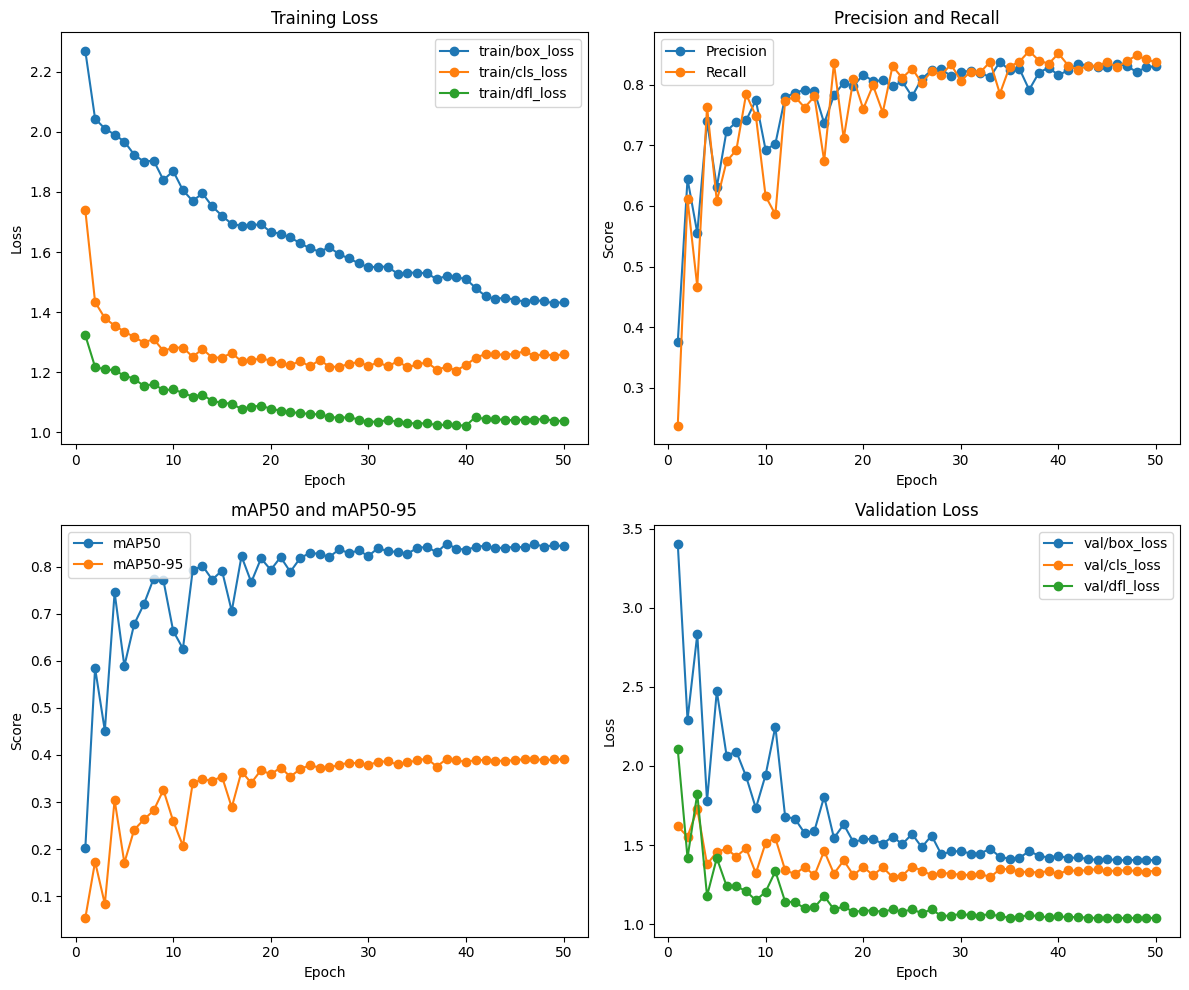

In [26]:
# Plotting selected metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting training loss
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='train/box_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/dfl_loss'], label='train/dfl_loss', marker='o')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting precision and recall
axes[0, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', marker='o')
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', marker='o')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()

# Plotting mAP50 and mAP50-95
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o')
axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='o')
axes[1, 0].set_title('mAP50 and mAP50-95')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()

# Plotting validation loss
axes[1, 1].plot(df['epoch'], df['val/box_loss'], label='val/box_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/dfl_loss'], label='val/dfl_loss', marker='o')
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Adjust layout and display
plt.tight_layout()

In [27]:
results = model.val()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /kaggle/working/val/labels.cache... 217 images, 36 backgrounds, 0 corrupt: 100%|██████████| 217/217 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/val/images/plasmodium-0575.jpg: 1 duplicate labels removed



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


                   all        217       4036      0.829       0.84      0.848      0.392
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detect/train2


In [28]:
print(results.box.map)  # mAP50-95
print(results.box.map50)  # mAP50
print(results.box.map75) 
print(results.box.maps) 

0.391947109360275
0.8480780928669207
0.2976891631100626
[    0.39195]



image 1/1 /kaggle/input/makerere-malaria-dataset/images/plasmodium-2035.jpg: 480x640 28 Trophozoites, 48.3ms
Speed: 2.8ms preprocess, 48.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


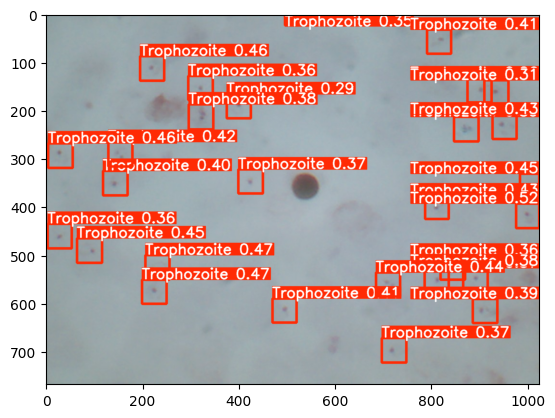

In [29]:
prediction = model.predict(test_data['images'].iloc[10])
plt.imshow(prediction[0].plot())

**PS. If you found this Notebook helpful kindly provide an upvote ;)**